**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install h5py pyyaml 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (158 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  60.0M      0  0:00:08  0:00:08 --:--:-- 76.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  37.5M      0 --:--:-- --:--:-- --:--:-- 37.4M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))  # Check how many dimensions are there in a slide 
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))  # downsample factor: 比原来小多少倍
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

## Load and Visualize the Original Slide

In [0]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(slide_image)

## Load and Visualize the Mask

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(mask_image)

## Overlay the Slide and the Mask

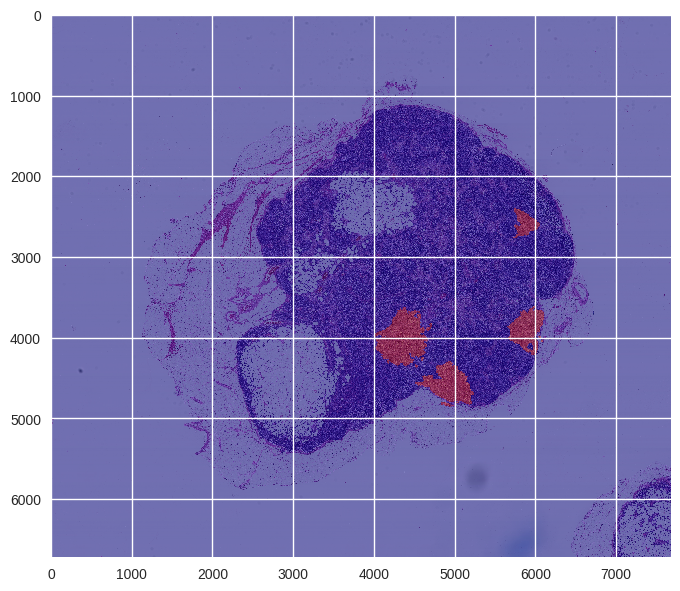

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(8,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
#plt.imshow(region)

13344403 tissue_pixels pixels (25.9 percent of the image)


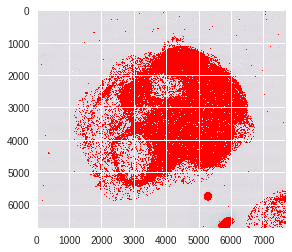

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):  
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# Eliminating Empty Area by Looking at the Original Image

In [0]:
tissue_area = slide_image[1000:7000, 1000:6000]
mask_tissue_area = mask_image[1000:7000, 1000:6000]

# Sliding Window Function

In [0]:
# Sliding window funtion

def sliding_window(image, stepSize, window_width, window_height):
  patches = []
  for x in range(0, image.shape[0] - window_width , stepSize):
    for y in range(0, image.shape[1] - window_height, stepSize):
      if len(image.shape) == 3:
        window = image[x:x + window_width, y:y + window_height, :]
      else:
        window = image[x:x + window_width, y:y + window_height]
      patches.append(window)
  return patches

# Create Patches

In [0]:
slide_patches = sliding_window(tissue_area, 64, 150, 150)

In [0]:
mask_patches = sliding_window(mask_tissue_area, 64, 150, 150)
mask_center_patches = []
for i in range(len(mask_patches)):
  mask_center_patches.append(mask_patches[i][43:43+64, 43:43+64])

**Create a label array**

In [0]:
label = np.zeros(len(mask_center_patches))
for i in range(len(mask_center_patches)):
  if np.sum(mask_center_patches[i]) == 0:
    label[i] = 0
  else:
    label[i] = 1

In [0]:
X_train = slide_patches # total training patches
y_train = label

In [0]:
len(slide_patches)

6688

# Separate Tumor and Normal Patches

In [0]:
tumor_patches = []
normal_patches = []

for i in range(len(y_train)):
  if y_train[i] == 0:
    normal_patches.append(X_train[i])
  else:
    tumor_patches.append(X_train[i])

# Data Augmentation on Tumor Patches

In [0]:
tumor_patches_90 = []
for i in tumor_patches:
  tumor_patches_90.append(np.rot90(i))
  
tumor_patches_180 = []
for i in tumor_patches_90:
  tumor_patches_180.append(np.rot90(i))
  
tumor_patches_270 = []
for i in tumor_patches_180:
  tumor_patches_270.append(np.rot90(i))

In [0]:
tumor_patches_flip = []
for i in tumor_patches:
  tumor_patches_flip.append(np.fliplr(i))

tumor_patches_90_flip = []
for i in tumor_patches_90:
  tumor_patches_90_flip.append(np.fliplr(i))

tumor_patches_180_flip = []
for i in tumor_patches_180:
  tumor_patches_180_flip.append(np.fliplr(i))
  
tumor_patches_270_flip = []
for i in tumor_patches_270:
  tumor_patches_270_flip.append(np.fliplr(i))

In [0]:
len(normal_patches)

6454

In [0]:
len(tumor_patches)

234

In [0]:
X_train = normal_patches + tumor_patches + tumor_patches_90 + tumor_patches_180 + tumor_patches_270 +tumor_patches_flip + tumor_patches_90_flip + tumor_patches_180_flip + tumor_patches_270_flip

In [0]:
y_train = [0]*len(normal_patches) + [1]*len(tumor_patches)*8

In [0]:
for i in range(len(X_train)):
  X_train[i] = (X_train[i]/255.0).reshape((1,) + X_train[i].shape)

In [0]:
X_train = np.concatenate(X_train, axis = 0)

In [0]:
y_train = np.array(y_train)

In [0]:
X_train.shape

(8326, 150, 150, 3)

In [0]:
y_train.shape

(8326,)

In [0]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Predicting on a New Slide

# Modeling: Using InceptionV3 as Base

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras import models
from keras import layers
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape = (150,150,3))

conv_base.trainable=False

87924736/87910968 [==============================] - 1s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
from keras import optimizers
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
history =  model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.1)

Train on 7493 samples, validate on 833 samples
Epoch 1/10
7493/7493 [==============================] - 31s 4ms/step - loss: 0.3052 - acc: 0.8778 - val_loss: 0.3502 - val_acc: 0.8571
Epoch 2/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.2105 - acc: 0.9141 - val_loss: 0.5337 - val_acc: 0.7743
Epoch 3/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.1646 - acc: 0.9299 - val_loss: 0.3091 - val_acc: 0.8643
Epoch 4/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.1470 - acc: 0.9435 - val_loss: 0.4985 - val_acc: 0.7863
Epoch 5/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.1423 - acc: 0.9414 - val_loss: 0.3659 - val_acc: 0.8391
Epoch 6/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.1351 - acc: 0.9433 - val_loss: 0.3066 - val_acc: 0.8595
Epoch 7/10
7493/7493 [==============================] - 25s 3ms/step - loss: 0.1247 - acc: 0.9517 - val_loss: 0.3117 - val_acc: 0.8619
Epoch 8/

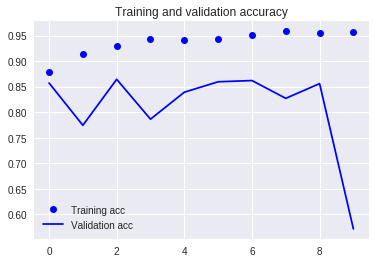

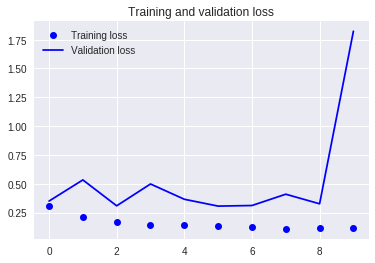

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Loading a New Slide

In [0]:
test_slide_path = 'tumor_110.tif'
test_tumor_mask_path = 'tumor_110_mask.tif'

test_slide_url = 'https://storage.googleapis.com/cancer_detection/%s' % test_slide_path
test_mask_url = 'https://storage.googleapis.com/cancer_detection/%s' % test_tumor_mask_path

# Download the whole slide image
if not os.path.exists(test_slide_path):
  !curl -O $test_slide_url

# Download the tumor mask
if not os.path.exists(test_tumor_mask_path):
  !curl -O $test_mask_url

In [0]:
test_slide = open_slide(test_slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (test_slide_path, 
                                                        test_slide.level_dimensions[0][0], 
                                                        test_slide.level_dimensions[0][1]))

test_tumor_mask = open_slide(test_tumor_mask_path)
print ("Read tumor mask from %s" % (test_tumor_mask_path))

print("Slide includes %d levels", len(test_slide.level_dimensions))  # Check how many dimensions are there in a slide 
for i in range(len(test_slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             test_slide.level_dimensions[i], 
                                                             test_slide.level_downsamples[i]))  # downsample factor: 比原来小多少倍
    assert test_tumor_mask.level_dimensions[i][0] == test_slide.level_dimensions[i][0]
    assert test_tumor_mask.level_dimensions[i][1] == test_slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = test_slide.level_dimensions[8]
assert width * test_slide.level_downsamples[8] == test_slide.level_dimensions[0][0]
assert height * test_slide.level_downsamples[8] == test_slide.level_dimensions[0][1]

Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


## Visualize the Test Slide Image

In [0]:
test_slide_image = read_slide(test_slide, 
                           x=0, 
                           y=0, 
                           level=5, 
                           width=test_slide.level_dimensions[5][0], 
                           height=test_slide.level_dimensions[5][1])

#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(test_slide_image)

## Visualize the Test Tumor Mask Image

In [0]:
test_mask_image = read_slide(test_tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=test_slide.level_dimensions[5][0], 
                        height=test_slide.level_dimensions[5][1])


test_mask_image = test_mask_image[:,:,0]

#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(test_mask_image)

## Overlay the Test Slide and the Test Tumor Mask 

## Generate Patches from Test Slide Image

In [0]:
#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(test_slide_image)
#plt.imshow(test_mask_image, cmap='jet', alpha=0.5)

In [0]:
test_slide_patches = sliding_window(test_slide_image, 64, 150, 150)

In [0]:
for i in range(len(test_slide_patches)):
  test_slide_patches[i] = (test_slide_patches[i]/255.0).reshape((1,) + test_slide_patches[i].shape)

In [0]:
test_slide_patches = np.concatenate(test_slide_patches, axis = 0)

In [0]:
test_slide_patches.shape

(1452, 150, 150, 3)

## Getting Testing Label

In [0]:
test_mask_patches = sliding_window(test_mask_image, 64, 150, 150)
test_mask_center_patches = []
for i in range(len(test_mask_patches)):
  test_mask_center_patches.append(test_mask_patches[i][43:43+64, 43:43+64])

In [0]:
test_label = np.zeros(len(test_mask_center_patches))
for i in range(len(test_mask_center_patches)):
  if np.sum(test_mask_center_patches[i]) == 0:
    test_label[i] = 0
  else:
    test_label[i] = 1

# Prediction

In [0]:
predictions = model.predict_classes(test_slide_patches)

In [0]:
predict_proba = model.predict_proba(test_slide_patches)

In [0]:
predict_proba.shape

(1452, 1)

In [0]:
prob_matrix = np.reshape(predict_proba, (-1, 44))

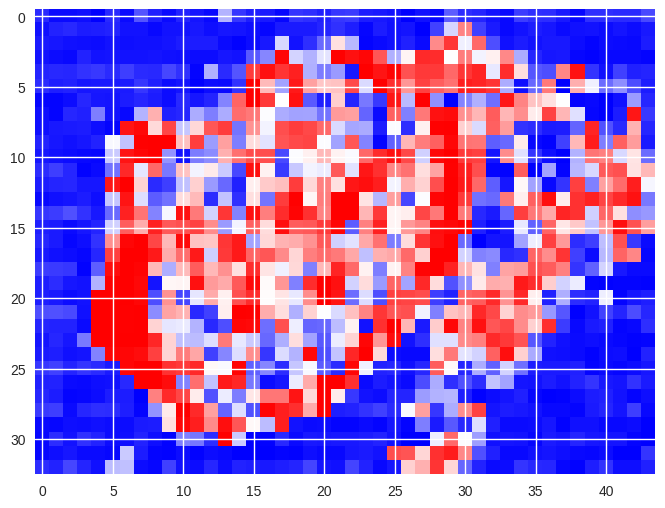

In [0]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(prob_matrix, cmap='bwr', interpolation='nearest')
plt.show()

In [0]:
np.sum(predictions)

546

# AUC

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#AUC score

roc_auc_score(test_label, predict_proba)

0.7489214415348717

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(test_label, predictions)
print(confusion_matrix)

[[767 335]
 [139 211]]


In [0]:
fpr, tpr, threshold = roc_curve(test_label, predict_proba)
roc_auc = auc(fpr, tpr)

In [0]:
precision = 211./(211+335)
print(precision)

0.386446886447


In [0]:
recall = 211./(211+139)
print(recall)

0.602857142857


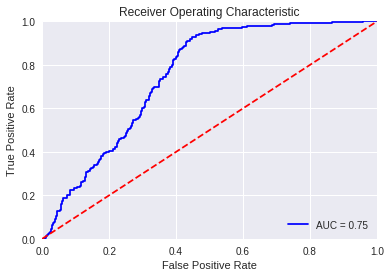

In [0]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

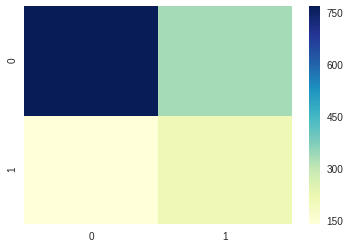

In [0]:
import seaborn as sns
sns.heatmap(confusion_matrix,cmap="YlGnBu")



---

